### Inference Notebook - PyTorch Assignment

This notebook conatins the information related to the task of infernce results. This contains 2 sections - generated faces from train dataset (16 in number) and then generated faces from test dataset (Unseen) which is also 16 in number

### Imports and Setup

In [41]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from models import Generator     
from encoder import FaceNetEncoder  
from dataset import get_celeba_dataloader
import warnings


warnings.filterwarnings("ignore")


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
CHECKPOINT_DIR = "./checkpoints/"
EMBEDDING_DIM = 512
NOISE_DIM = 100


def show_tensor_images(image_tensor, title, num_images=16):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

print("Setup complete. Ready to load models.")

Setup complete. Ready to load models.


### Display of Real Images

Fetching a batch of real images to test with...
--- Using Hugging Face 'flwrlabs/celeba' dataset in streaming mode ---
Initializing dataset stream...
Hugging Face DataLoader created successfully!
Successfully generated embeddings from the real images.


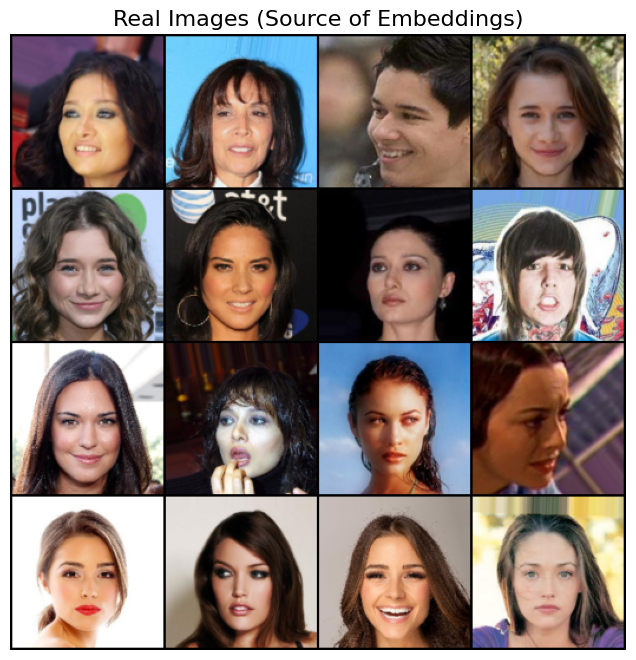

In [43]:
encoder = FaceNetEncoder(device=DEVICE)
encoder.eval() 


print("Fetching a batch of real images to test with...")
dataloader = get_celeba_dataloader(batch_size=16)
real_batch = next(iter(dataloader))
real_images = real_batch['image'].to(DEVICE)

with torch.no_grad():
    unseen_embeddings = encoder(real_images)

print("Successfully generated embeddings from the real images.")

show_tensor_images(real_images, title="Real Images (Source of Embeddings)")

Generating images with the model trained after 2 epoch


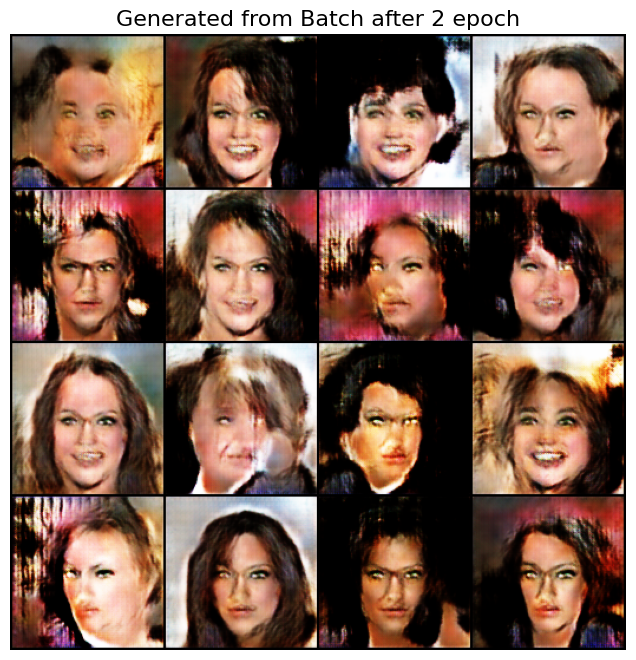

In [44]:
generator_after2Epoch = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(DEVICE)

# Load the saved weights from the batch 1000 checkpoint
generator_after2Epoch.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/generator_epoch_2.pth", map_location=DEVICE))
generator_after2Epoch.eval() # Set to evaluation mode

print("Generating images with the model trained after 2 epoch")
with torch.no_grad():
    noise = torch.randn(16, NOISE_DIM, device=DEVICE)
    generated_after2Epoch = generator_after2Epoch(noise, unseen_embeddings)

show_tensor_images(generated_after2Epoch, title="Generated from Batch after 2 epoch")

### Generated face images from Unseen Test Data , inference run on 16 images from Test Data below

In [45]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset

def get_celeba_test_dataloader(batch_size, image_size):
    """Creates a DataLoader for the CelebA TEST split."""
    print("--- Preparing CelebA test dataloader (streaming) ---")
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # To range [-1, 1]
    ])

    def transform_example(example):
        example['image'] = preprocess(example['image'].convert("RGB"))
        return example

    # Use the 'test' split of the dataset
    dataset = load_dataset("flwrlabs/celeba", split="test", streaming=True)
    transformed_dataset = dataset.map(transform_example)
    final_dataset = transformed_dataset.with_format("torch")

    dataloader = DataLoader(final_dataset, batch_size=batch_size)
    print("Test DataLoader created successfully!")
    return dataloader

In [46]:
def show_tensor_images(image_tensor, title, num_images=16):
    """Display a grid of tensor images."""
    image_tensor = (image_tensor + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

Fetching a batch of UNSEEN test images...
--- Preparing CelebA test dataloader (streaming) ---
Test DataLoader created successfully!
Generating embeddings from unseen test images...
Successfully generated embeddings from the test images.


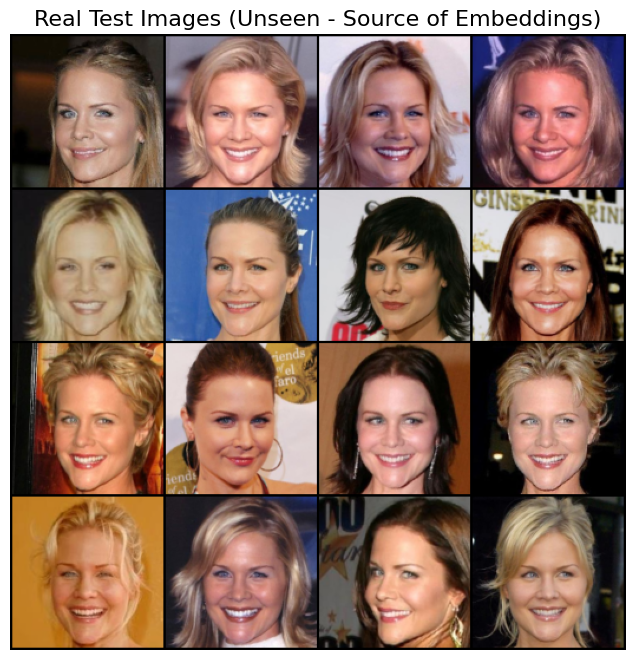

In [48]:
encoder = FaceNetEncoder(device=DEVICE)
encoder.eval() 

# Load test data (unseen images)
print("Fetching a batch of UNSEEN test images...")
test_dataloader = get_celeba_test_dataloader(batch_size=16, image_size=128)
test_batch = next(iter(test_dataloader))
test_images = test_batch['image'].to(DEVICE)

# Generate embeddings from the test images
print("Generating embeddings from unseen test images...")
with torch.no_grad():
    test_embeddings = encoder(test_images)

print("Successfully generated embeddings from the test images.")

# Show the real test images
show_tensor_images(test_images, title="Real Test Images (Unseen - Source of Embeddings)")

Generating images with the model trained after 2 epochs using test embeddings...


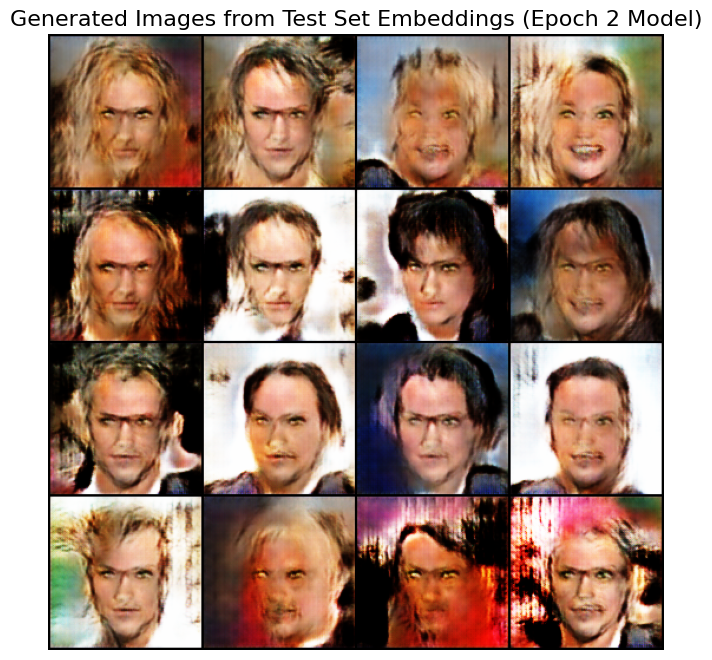

In [49]:
generator_after2Epoch = Generator(noise_dim=NOISE_DIM, embedding_dim=EMBEDDING_DIM).to(DEVICE)

# Load the saved weights from epoch 2
generator_after2Epoch.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/generator_epoch_2.pth", map_location=DEVICE))
generator_after2Epoch.eval()  # Set to evaluation mode

print("Generating images with the model trained after 2 epochs using test embeddings...")
with torch.no_grad():
    noise = torch.randn(16, NOISE_DIM, device=DEVICE)
    generated_from_test = generator_after2Epoch(noise, test_embeddings)

# Show the generated images based on test embeddings
show_tensor_images(generated_from_test, title="Generated Images from Test Set Embeddings (Epoch 2 Model)")